# National Survey on Drug Use and Health Analysis
### Data from: 2012 (ICPSR 34933)

## Machine Learning to Predict Drug Use
In this notebook, we use XGBoost and Random Forest to attempt to classify if someone will try hard drugs
from several background factors:

### Data
* IRWELMOS: IMP. REVISED - NO.OF MONTHS ON WELFARE

    RANGE = 1 - 12

    99 = LEGITIMATE SKIP

* IRFAMIN3: RECODE - IMP.REVISED - TOT FAM INCOME

    1 = Less than \$10,000 (Including Loss)
    
    2 = \$10,000 - 19,999 
  
    3 = \$20,000 - 29,999 
  
    4 = \$30,000 - 39,999 
  
    5 = \$40,000 - 49,999 
  
    6 = \$50,000 - 74,999 
    
    7 = \$75,000 or more

* NOMARR2 Len: 2 NUMBER OF TIMES MARRIED

    1 = One time
    
    2 = Two or more times
    
    94 = DON'T KNOW
    
    97 = REFUSED
    
    99 = LEGITIMATE SKIP 

* HEALTH: OVERALL HEALTH

    1 = Excellent 
    
    2 = Very good 
    
    3 = Good 
    
    4 = Fair 
    
    5 = Poor 
    
    94 = DON'T KNOW 
    
    97 = REFUSED 

* IRSEX: IMPUTATION REVISED GENDER

    1 = Male
    
    2 = Female 
    
* IREDUC2: RECODE - IMPUTATION REVISED EDUCATION Freq Pct

    1 = Fifth grade or less
    
    2 = Sixth grade 
    
    3 = Seventh grade
    
    4 = Eighth grade
    
    5 = Ninth grade
    
    6 = Tenth grade
    
    7 = Eleventh grade
    
    8 = Twelfth grade 
    
    9 = Freshman/13th year 
    
    10 = Sophomore/14th year or Junior/15th year 
    
    11 = Senior/16th year or Grad/Prof School (or higher) 

* NEWRACE2: RACE/HISPANICITY RECODE (7 LEVELS) Freq Pct

    1 = NonHisp White
    
    2 = NonHisp Black/Afr Am
    
    3 = NonHisp Native Am/AK Native
    
    4 = NonHisp Native HI/Other Pac Isl 
    
    5 = NonHisp Asian
    
    6 = NonHisp more than one race
    
    7 = Hispanic 
    
* MOVESPY2: # TIMES MOVED PAST 12 MONTHS Freq Pct

    0 = None
    
    1 = One time 
    
    2 = Two times
    
    3 = Three or more times 
    
    994 = DON'T KNOW
    
    997 = REFUSED
    
    998 = BLANK (NO ANSWER) 
    
* JBSTATR2: WORK SITUATION IN PAST WEEK - RECODE Freq Pct

    1 = Worked at full-time job, past week
    
    2 = Worked at part time job, past week
    
    3 = Has job or volunteer worker, did not work past wk
    
    4 = Unemployed/on layoff, looking for work
    
    5 = Disabled
    
    6 = Keeping house full-time
    
    7 = In school/training
    
    8 = Retired
    
    9 = Does not have a job, some other reason
    
    10 = MISSING
    
    11 = LEGITIMATE SKIP

### Labels
* COCEVER: EVER USED COCAINE

    1 = yes
    
    0 = no
    
* HEREVER: EVER USED HEROIN

    1 = yes
    
    0 = no

* --HALLUCINOGENS
* LSD: EVER USED LSD ("ACID")

    1 = yes
    
    0 = no

* --INHALANTS
* AMYLNIT: EVER INHALED AMYL NITRITE, 'POPPERS,' RUSH, ETC. Freq Pct

    1 = yes
    
    0 = no

* --PAIN RELIEVERS
* DARVTYLC: EVER USED DARVOCET, DARVON, OR TYLENOL W/ CODEINE

    1 = yes
    
    0 = no

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def visualize_data(df, rows=None):
    df_corr = df.corr()
    print(df_corr.head(10))

    data = df_corr.values
    
    if rows is not None:
        data = data[rows].reshape(len(rows), data.shape[1])
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)

    ax.set_xticks(np.arange(data.shape[0]), minor=False)
    ax.set_yticks(np.arange(data.shape[1]), minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    plt.xticks(rotation=90)
    heatmap.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()

In [4]:
# Load the data
data = pd.read_csv('DS0001/34933-0001-Data.tsv', sep='\t', header=0)
print(data.shape)
print(data.head())
# check for missing values
print(data[np.isinf(data.values).any(axis=1)])
print(data[np.isnan(data.values).any(axis=1)])

(55268, 3120)
   CASEID  QUESTID2  CIGEVER  CIGOFRSM  CIGWILYR  CIGTRY  CIGYFU  CIGMFU  \
0       1  50886467        2         4         4     991    9991      91   
1       2  13766883        2        99        99     991    9991      91   
2       3  17772877        2        99        99     991    9991      91   
3       4  45622817        1        99        99      13    9999      99   
4       5  17239390        1        99        99      11    9999      99   

   CIGREC  CIG30USE  ...  IIEMPSTY  II2EMSTY  EMPSTAT4  IIEMPST4  II2EMST4  \
0      91        91  ...         1         1        99         9         9   
1      91        91  ...         1         1         1         1         1   
2      91        91  ...         1         1         1         1         1   
3       2        93  ...         1         1         2         1         1   
4       4        93  ...         1         1         1         1         1   

   PDEN00  COUTYP2      ANALWT_C  VESTR  VEREP  
0       2  

We start by selecting the columns that will be our features and the columns that will be our labels.

In [5]:
# clean the data up
features = ["IRWELMOS", "IRFAMIN3", "NOMARR2", "HEALTH", "IRSEX", "IREDUC2", "NEWRACE2", "MOVESPY2", "JBSTATR2"]
labels = ["COCEVER", "HEREVER", "LSD", "AMYLNIT", "DARVTYLC"]

data_selection = data[features]
labels_selection = data[labels]

We then process our labels so that if someone has ever used cocaine, heroin, LSD, inhalants or non prescribed prescription
pain pills, the will be marked as a hard drug user.

In [6]:
# process labels
# COCAINE
labels_selection.loc[labels_selection['COCEVER'] != 1, 'COCEVER'] = 0

# HEROIN
labels_selection.loc[labels_selection['HEREVER'] != 1, 'HEREVER'] = 0

# HALLUCINOGENS
labels_selection.loc[labels_selection['LSD'] != 91, 'LSD'] = 1
labels_selection.loc[labels_selection['LSD'] == 91, 'LSD'] = 0

# INHALANTS
labels_selection.loc[labels_selection['AMYLNIT'] != 91, 'AMYLNIT'] = 1
labels_selection.loc[labels_selection['AMYLNIT'] == 91, 'AMYLNIT'] = 0

# PAIN RELIEVERS
labels_selection.loc[(labels_selection["DARVTYLC"] == 91) | (labels_selection["DARVTYLC"] == 81), 'DARVTYLC'] = 0
labels_selection.loc[(labels_selection["DARVTYLC"] != 0), 'DARVTYLC'] = 1

labels = np.zeros((labels_selection.shape[0], 1))
for i, row in enumerate(labels_selection.iterrows()):
    if 1 in list(row[1].as_matrix()):
        labels[i] = 1
        
print(labels[:20])
print(labels_selection.head(20))

D:\Anaconda3\envs\econ\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]
    COCEVER  HEREVER  LSD  AMYLNIT  DARVTYLC
0         0        0    0        0         0
1         0        0    0        0         0
2         0        0    0        0         0
3         1        0    1        0         0
4         0        0    0        0         0
5         0        0    0        0         0
6         0        0    0        0         0
7         0        0    0        0         0
8         0        0    0        0         0
9         1        1    1        0         1
10        0        0    0        0         0
11        0        0    0        0         0
12        0        0    0        0         0
13        0        0    0        0         1
14        0        0    0        0         0
15        0        0    0        0         0
16        0        0    0        0         0
17        0        0    0        0         0
18        0        0    

## Metric Choice
In the experiments we are doing, we use three metrics, accuracy, ROCAUC, and F1 score. Accuracy is generally 
considered a rather poor metric, as especially in an unbalanced class situation, you can have a decent accuracy,
and pretty horrendous real life performance. Thus we turn to ROCAUC and F1 score. In our application, since we have 
imbalanced data, *we will focus on F1 score* as it is a better indicator of performance at a given threshold value,
where as ROCAUC will average the score over all the possible threshold values. You can read more about this trade-off
and what these metric intuitively mean at the links below.

[ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

[F1 Score vs ROC AUC)](https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc)

## One Hot Encoding
All of our features are categorical variables, a natural reaction would be to one hot encoding all of our features.
We will see that this may not be the wisest choice, considering we are using decision tree based methods for modeling
(XGBoost and Random Forest). We discuss this more in the conclusion of this notebook. For the time being, we will 
experiment with one hot encoding our variables.
We can also see that our data is rather class imbalanced, with about twice as many negative examples
as positive examples. We will explore one possible way to deal with this later on.

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(categories='auto')
x = onehotencoder.fit_transform(data_selection.values).toarray()

# shuffle the data
order = np.arange(x.shape[0])
np.random.shuffle(order)
x = x[order]
y = labels[order]

train_data = x[:int(x.shape[0] * 0.8)]
test_data = x[int(x.shape[0] * 0.8):]

train_labels = y[:int(x.shape[0] * 0.8)]
test_labels = y[int(x.shape[0] * 0.8):]

unique, counts = np.unique(train_labels, return_counts=True)
print("Train Label Counts")
print(dict(zip(unique, counts)))
print(f"{unique[0]}: {round(counts[0]/sum(counts)*100, 3)}%")
print(f"{unique[1]}: {round(counts[1]/sum(counts)*100, 3)}%")

unique, counts = np.unique(test_labels, return_counts=True)
print("Test Label Counts")
print(dict(zip(unique, counts)))
print(f"{unique[0]}: {round(counts[0]/sum(counts)*100, 3)}%")
print(f"{unique[1]}: {round(counts[1]/sum(counts)*100, 3)}%")


Train Label Counts
{0.0: 32285, 1.0: 11929}
0.0: 73.02%
1.0: 26.98%
Test Label Counts
{0.0: 8031, 1.0: 3023}
0.0: 72.652%
1.0: 27.348%


## Visualize The Data
We can see the data is heavily intertwined, as the blue (not a hard drug user) and the red (hard drug user) are mixed
and not clearly separated.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.063s...
[t-SNE] Computed neighbors for 5000 samples in 4.440s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.853117
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.642181
[t-SNE] KL divergence after 300 iterations: 2.853111


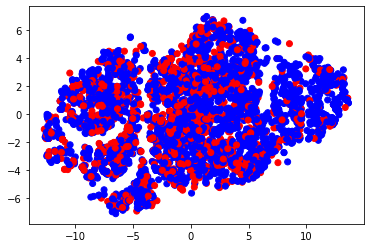

In [8]:
from sklearn.manifold import TSNE
import matplotlib
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train_data[:5000])
colors= ["blue", "red"]

c = train_labels[:5000].reshape((5000,))
plt.scatter(x=tsne_results[:, 0], y=tsne_results[:, 1], c=c, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

# Helper methods
def print_scores(train_y_true, train_y_preds, test_y_true, test_y_preds):
    train_y_preds_class = np.argmax(train_y_preds, axis=1)
    test_y_preds_class = np.argmax(test_y_preds, axis=1)
    
    print("Train Accuracy {}".format(accuracy_score(train_y_true, train_y_preds_class)))
    print("Test Accuracy {}".format(accuracy_score(test_y_true, test_y_preds_class)))
    
    print("Train ROC AUC {}".format(roc_auc_score(train_y_true, train_y_preds[:, 1])))
    print("Test ROC AUC {}".format(roc_auc_score(test_y_true, test_y_preds[:, 1])))
    
    print("Train F1 Score {}".format(f1_score(train_y_true, train_y_preds_class)))
    print("Test F1 Score {}".format(f1_score(test_y_true, test_y_preds_class)))
    
    print(confusion_matrix(test_labels, test_y_preds_class))
    
    
def plot_curves(labels, preds):
    fig = plt.figure(figsize=(12, 6))
    grid = (1, 2)
    
    ax1 = plt.subplot2grid(grid, (0,0), rowspan=1, colspan=1)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(labels, preds[:, 1])
    ax1.plot([0, 1], [0, 1], linestyle='--') # random
    ax1.plot(fpr, tpr, marker='.')
    ax1.set_title("ROC Curve")
    
    ax2 = plt.subplot2grid(grid, (0,1), rowspan=1, colspan=1)
    # calculate precision recall curve
    precision, recall, thresholds = precision_recall_curve(labels, preds[:, 1])
    ax2.plot(precision, recall, marker='.')
    ax2.set_title("Precision Recall Curve")
    
    plt.show()
    
    

###  XGBoost With One Hot Encoded Features
We begin by experimenting with XGBoost using the one hot encoded features. We can see that the model's performance is
not particularly stellar. The train metrics (AUCROC and accuracy) are decent but the F1 sore is rather subpar. Since the
classes are imbalanced in this dataset, we give preference to the F1 score. We can see that the precision recall curve
and the ROC curve for the test data both show poor results. 

D:\Anaconda3\envs\econ\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda3\envs\econ\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy 0.8109874700321166
Test Accuracy 0.7173873710873891
Train ROC AUC 0.852354389458262
Test ROC AUC 0.6529883395524118
Train F1 Score 0.5116578040086484
Test F1 Score 0.25334608030592737
[[7400  631]
 [2493  530]]


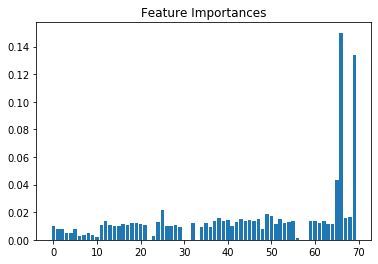

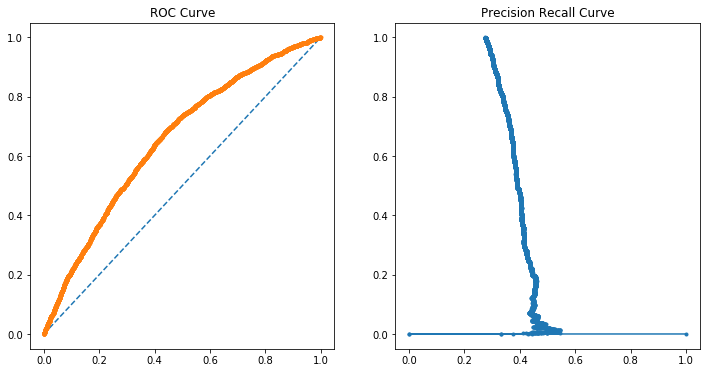

In [10]:
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=10, n_estimators=500, n_jobs=-1)
model.fit(train_data, train_labels)

train_preds = model.predict_proba(train_data)
test_preds = model.predict_proba(test_data)

print_scores(train_labels, train_preds, test_labels, test_preds)

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("Feature Importances")
plt.show()

plot_curves(test_labels, test_preds)

###  Random Forest With One Hot Encoded Features
Next we experiment with a Random Forest model using our one hot encoded features. We can see that the model is even
worse than the XGBoost model. We can see that the scores for the test and train set are about equal, suggesting that we
could potentially expand the model or train for longer. The F1 scores however are quite abysmal, which is not promising
being that we are using the F1 score as our primary metric. We can see that the model is struggling with false negatives
based on the confusion matrix, so it is struggling to identify hard drug users, suggesting a similar case to what t-sne
showed us, the data is heavily mixed.

D:\Anaconda3\envs\econ\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Train Accuracy 0.7339756638168906
Test Accuracy 0.7264338700922743
Train ROC AUC 0.7290227582007753
Test ROC AUC 0.6833482420687649
Train F1 Score 0.03241197762421849
Test F1 Score 0.01498371335504886
[[8007   24]
 [3000   23]]


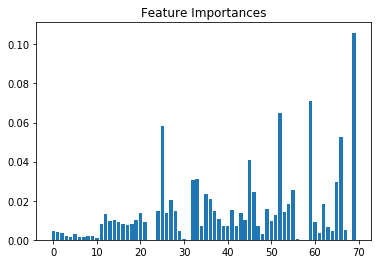

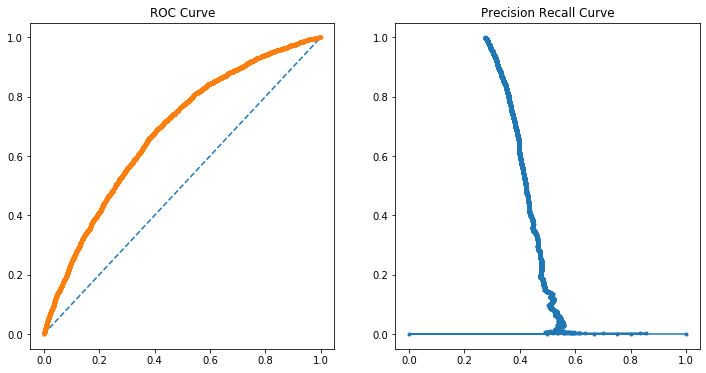

In [12]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1)
model.fit(train_data, train_labels)

train_preds = model.predict_proba(train_data)
test_preds = model.predict_proba(test_data)

print_scores(train_labels, train_preds, test_labels, test_preds)

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("Feature Importances")
plt.show()

plot_curves(test_labels, test_preds)

## Raw Feature Models
Since our one hot features performed rather poorly, we can try out using the raw features. This result eludes to something
we will explore in the conclusion.

In [14]:
x = data_selection.values

# shuffle the data
order = np.arange(x.shape[0])
np.random.shuffle(order)
x = x[order]
y = labels[order]

train_data = x[:int(x.shape[0] * 0.8)]
test_data = x[int(x.shape[0] * 0.8):]

train_labels = y[:int(x.shape[0] * 0.8)]
test_labels = y[int(x.shape[0] * 0.8):]

###  XGBoost With Raw Features
We can see that XGBoost performs slightly better using the raw features, nothing stellar, but a few points gain on some
of our metrics.

Train Accuracy 0.8332880987922378
Test Accuracy 0.7062601773113805
Train ROC AUC 0.8851902329575174
Test ROC AUC 0.6282823446820835
Train F1 Score 0.5958216811975653
Test F1 Score 0.27699844132709867
[[7185  864]
 [2383  622]]


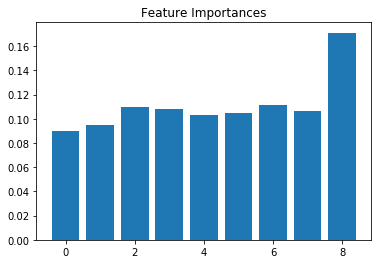

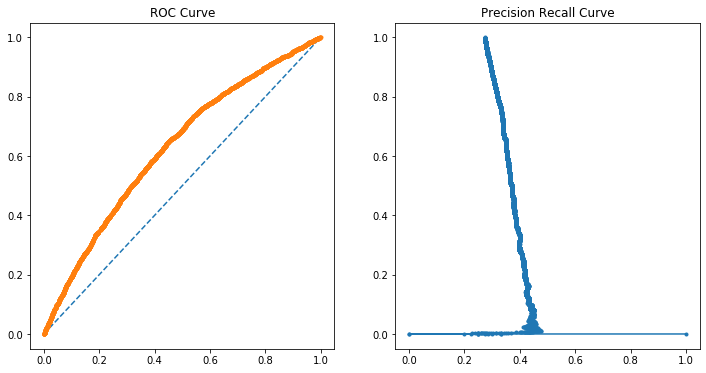

In [15]:
model = XGBClassifier(max_depth=10, n_estimators=500, n_jobs=-1)
model.fit(train_data, train_labels)

train_preds = model.predict_proba(train_data)
test_preds = model.predict_proba(test_data)

print_scores(train_labels, train_preds, test_labels, test_preds)

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("Feature Importances")
plt.show()

plot_curves(test_labels, test_preds)

###  Random Forest With Raw Features

We can see that the Random Forest improved rather substantially in F1 score using the raw features over the one hot
features. This still doesn't compete with XGBoost, but it is at least an improvement.

D:\Anaconda3\envs\econ\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Train Accuracy 0.7488578278373366
Test Accuracy 0.7345757191966709
Train ROC AUC 0.7486059589500739
Test ROC AUC 0.6881343865330672
Train F1 Score 0.17942654448714157
Test F1 Score 0.11573236889692587
[[7928  121]
 [2813  192]]


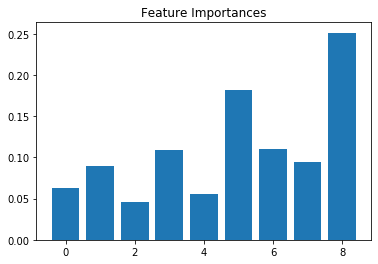

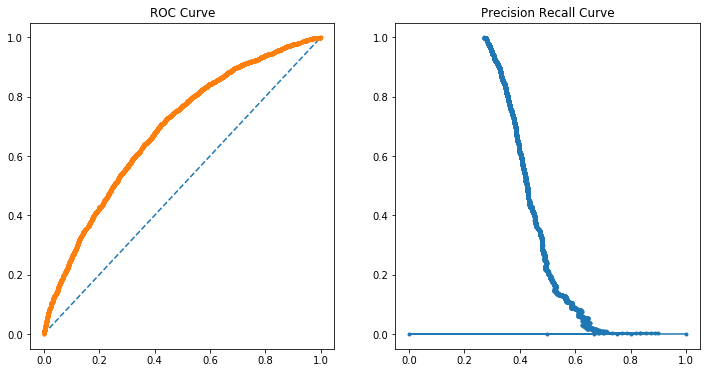

In [16]:
model = RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1)
model.fit(train_data, train_labels)

train_preds = model.predict_proba(train_data)
test_preds = model.predict_proba(test_data)

print_scores(train_labels, train_preds, test_labels, test_preds)

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("Feature Importances")
plt.show()

plot_curves(test_labels, test_preds)

## Over Sampling Data Models (ADASYN)
Since we have such a large class imbalance in the dataset, one possible way for correcting for it is using a methods
called over sampling. Over sampling tries to generate more samples close to the minority class examples in an attempt
to create more minority points, helping to correct for the class imbalance. Two common methods of over sampling are SMOTE
and ADASYN. SMOTE finds the k-nearest neighbors in the minority class for each of the samples in the  class, then draws 
lines to the neighbors an generates random points on those lines. ADASYN is simply an improved version of SMOTE. After 
creating those sample it adds a small amount of noise to the points, making it more realistic.

Below we can see that our class balances have been corrected to ~50/50. We also again try experimenting with one hotting
the data.

In [17]:
from imblearn.over_sampling import ADASYN 

# separate the data into train and test
x = data_selection.values
train_data = x[:int(x.shape[0] * 0.8)]
test_data = x[int(x.shape[0] * 0.8):]

train_labels = labels[:int(x.shape[0] * 0.8)]
test_labels = labels[int(x.shape[0] * 0.8):]

# only perform ADAYSN on the train data (prevents test set contamination)
sm = ADASYN()
train_data, train_labels = sm.fit_sample(train_data, train_labels)

# one hot data
onehotencoder = OneHotEncoder(categories='auto')
train_data = onehotencoder.fit_transform(train_data).toarray()
test_data = onehotencoder.transform(test_data).toarray()

# shuffle the data
order = np.arange(train_data.shape[0])
np.random.shuffle(order)
train_data = train_data[order]
train_labels = train_labels[order]

test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))

unique, counts = np.unique(train_labels, return_counts=True)
print("Train Label Counts")
print(dict(zip(unique, counts)))
print(f"{unique[0]}: {round(counts[0]/sum(counts)*100, 3)}%")
print(f"{unique[1]}: {round(counts[1]/sum(counts)*100, 3)}%")

unique, counts = np.unique(test_labels, return_counts=True)
print("Test Label Counts")
print(dict(zip(unique, counts)))
print(f"{unique[0]}: {round(counts[0]/sum(counts)*100, 3)}%")
print(f"{unique[1]}: {round(counts[1]/sum(counts)*100, 3)}%")

D:\Anaconda3\envs\econ\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Label Counts
{0.0: 32186, 1.0: 33787}
0.0: 48.787%
1.0: 51.213%
Test Label Counts
{0.0: 8130, 1.0: 2924}
0.0: 73.548%
1.0: 26.452%


### Visualizing the Data
We can see that the data is much more clustered this time, perhaps this is due to the nature of using nearest neighbors
to generate points close to each other.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.087s...
[t-SNE] Computed neighbors for 5000 samples in 3.809s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.832506
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.727798
[t-SNE] KL divergence after 300 iterations: 2.674344


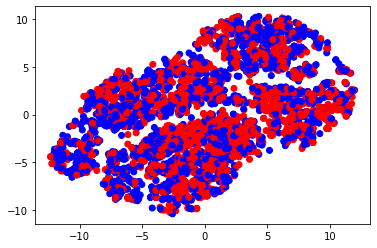

In [18]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train_data[:5000])
colors= ["blue", "red"]

c = train_labels[:5000].reshape((5000,))
plt.scatter(x=tsne_results[:, 0], y=tsne_results[:, 1], c=c, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

###  XGBoost With ADASYN One-Hot
Experimenting with XGBoost again, we can see that while the accuracy of the model dropped, it maintained the ROCAUC 
score in greatly improved the F1 scores, both on train and test. This is s very promising result as it suggests that
XGBoost is learning more robust features.

Train Accuracy 0.764782562563473
Test Accuracy 0.6095531029491587
Train ROC AUC 0.8533294437428527
Test ROC AUC 0.6396296375754456
Train F1 Score 0.781977070922783
Test F1 Score 0.4486458865610628
[[4982 3148]
 [1168 1756]]


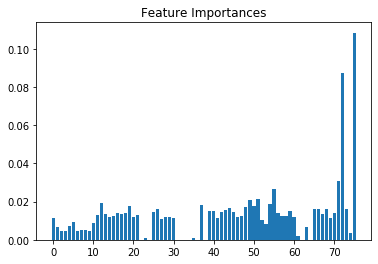

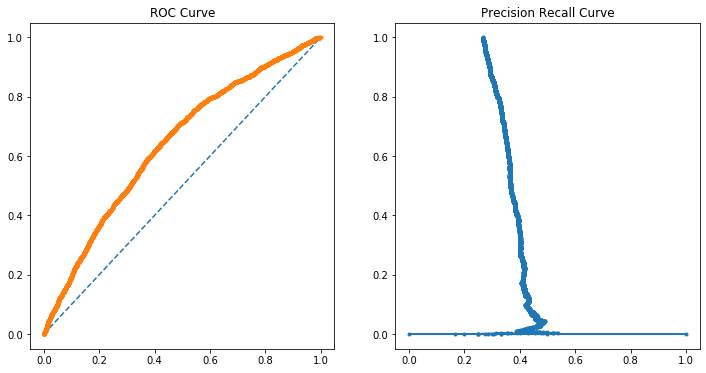

In [19]:
model = XGBClassifier(max_depth=10, n_estimators=500, n_jobs=-1)
model.fit(train_data, train_labels)

train_preds = model.predict_proba(train_data)
test_preds = model.predict_proba(test_data)

print_scores(train_labels, train_preds, test_labels, test_preds)

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("Feature Importances")
plt.show()

plot_curves(test_labels, test_preds)

###  Random Forest with ADASYN One-Hot
Experimenting with the Random Forest again, we can see that while the accuracy of the model dropped similar to XGBoost,
but also maintained the ROCAUC score in again substantially improved the F1 scores, even better than our raw features in
the first section.

Train Accuracy 0.6570263592681854
Test Accuracy 0.5962547494119775
Train ROC AUC 0.714103131506034
Test ROC AUC 0.6718290165117794
Train F1 Score 0.6864285813273465
Test F1 Score 0.4763580898744573
[[4561 3569]
 [ 894 2030]]


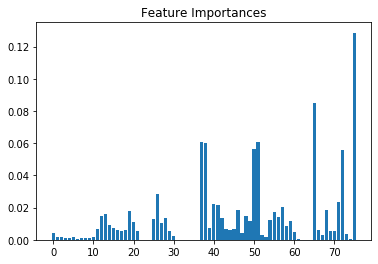

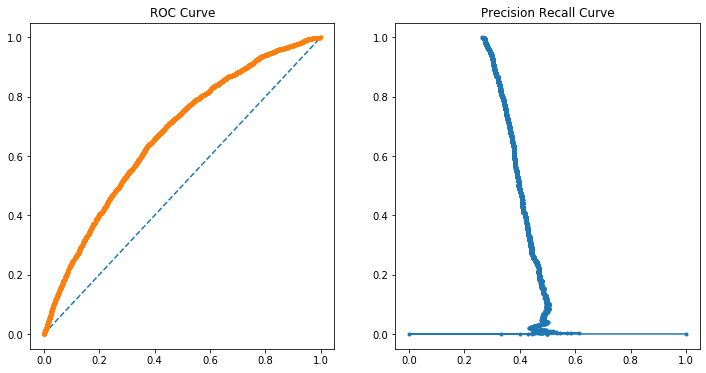

In [20]:
model = RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1)
model.fit(train_data, train_labels)

train_preds = model.predict_proba(train_data)
test_preds = model.predict_proba(test_data)

print_scores(train_labels, train_preds, test_labels, test_preds)

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("Feature Importances")
plt.show()

plot_curves(test_labels, test_preds)

## Over Sampling With Raw Features
We now repeat our experiment with over sampling the raw features this time.

In [21]:
from imblearn.over_sampling import ADASYN 

# seperate the data into train and test
x = data_selection.values
train_data = x[:int(x.shape[0] * 0.8)]
test_data = x[int(x.shape[0] * 0.8):]

train_labels = labels[:int(x.shape[0] * 0.8)]
test_labels = labels[int(x.shape[0] * 0.8):]

# only perform ADAYSN on the train data (prevents test set contamination)
sm = ADASYN()
train_data, train_labels = sm.fit_sample(train_data, train_labels)

# shuffle the data
order = np.arange(train_data.shape[0])
np.random.shuffle(order)
train_data = train_data[order]
train_labels = train_labels[order]

test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))

unique, counts = np.unique(train_labels, return_counts=True)
print("Train Label Counts")
print(dict(zip(unique, counts)))
print(f"{unique[0]}: {round(counts[0]/sum(counts)*100, 3)}%")
print(f"{unique[1]}: {round(counts[1]/sum(counts)*100, 3)}%")

unique, counts = np.unique(test_labels, return_counts=True)
print("Test Label Counts")
print(dict(zip(unique, counts)))
print(f"{unique[0]}: {round(counts[0]/sum(counts)*100, 3)}%")
print(f"{unique[1]}: {round(counts[1]/sum(counts)*100, 3)}%")

D:\Anaconda3\envs\econ\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Label Counts
{0.0: 32186, 1.0: 33787}
0.0: 48.787%
1.0: 51.213%
Test Label Counts
{0.0: 8130, 1.0: 2924}
0.0: 73.548%
1.0: 26.452%


###  XGBoost With ADASYN Raw Features
Using the over sampled raw features with XGBoost, the model is extremely close to the results we saw with the over
sampled one hot features, which is similar to what we saw with the original unbalanced data. However, the scores seem
to be much more robust that the original data model we made.

Train Accuracy 0.7775302017492004
Test Accuracy 0.6091912429889633
Train ROC AUC 0.8692388823861916
Test ROC AUC 0.6297711352626522
Train F1 Score 0.7932904243482669
Test F1 Score 0.4370602032838155
[[5057 3073]
 [1247 1677]]


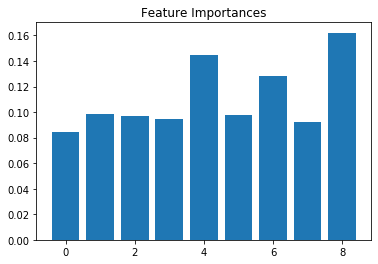

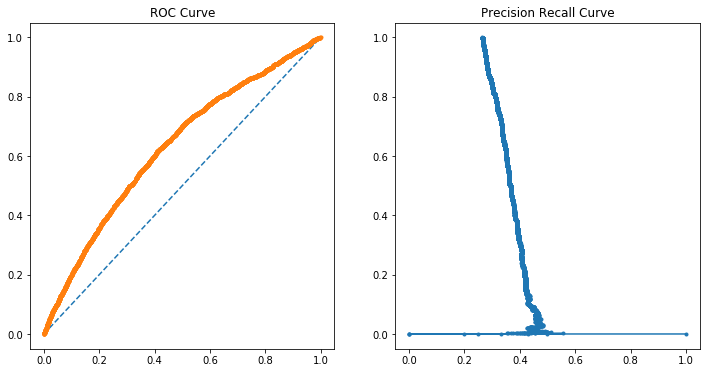

In [22]:
model = XGBClassifier(max_depth=10, n_estimators=500, n_jobs=-1)
model.fit(train_data, train_labels)

train_preds = model.predict_proba(train_data)
test_preds = model.predict_proba(test_data)

print_scores(train_labels, train_preds, test_labels, test_preds)

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("Feature Importances")
plt.show()

plot_curves(test_labels, test_preds)

###  Random Forest with ADASYN Raw Features
Using the over sampled raw features with the Random Forest, the model is also extremely close to the results we saw 
with the over sampled one hot features, which is disappointing considering the improvements gained in the origianal 
unbalanced data between one hot data and the raw feature data. Potentially a larger model would help to reproduce what
we saw in the previous section, but we would ned to watch for overfitting.

Train Accuracy 0.6735937428948207
Test Accuracy 0.6049393884566673
Train ROC AUC 0.7360233430676424
Test ROC AUC 0.6746841678403104
Train F1 Score 0.7001086260201097
Test F1 Score 0.47881608783864416
[[4681 3449]
 [ 918 2006]]


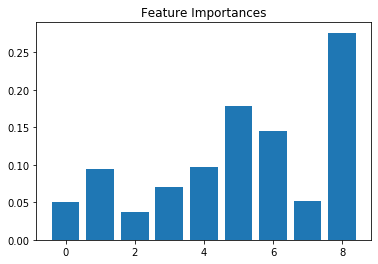

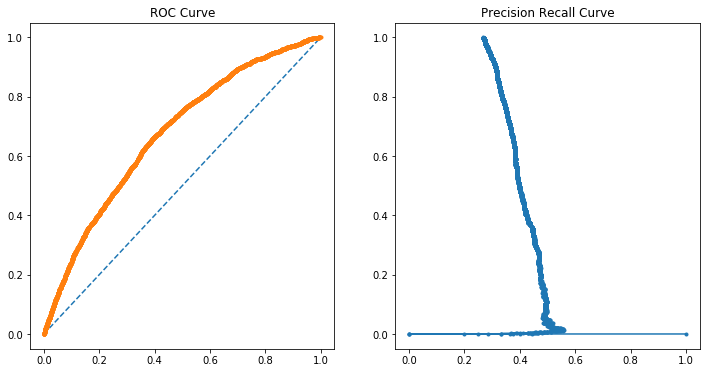

In [23]:
model = RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1)
model.fit(train_data, train_labels)

train_preds = model.predict_proba(train_data)
test_preds = model.predict_proba(test_data)

print_scores(train_labels, train_preds, test_labels, test_preds)

plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title("Feature Importances")
plt.show()

plot_curves(test_labels, test_preds)

###  Conclusion
Overall we find similar results to what most Kaggle enthusiasts know, XGBoost is an extremely robust model. Prior to over
sampling, XGBoost far out performed random forest, and even after over sampling, still handily had the lead. We also saw
that this is a rather challenging set of data to extract if someone will be a hard drug user from. With over 3000 features,
to choose from, we likely could find better features to use in this modeling process. However, we were able to still glean
some some decent results from the data we were using. Several potential future research projects could be:
* Identifying better features
* Using different models
* Using feature embedding to learn the relationship between the features better
* Trying out under sampling and comparing it to our results


#### One Hot v Raw Features with Tree Models
Due to the nature of tree based models, they create splits based on the features presented to them during training. These
splits are based on that split will result in the most gained "information". With one hotting our data, we end up with a 
tree model that is very sparse, as it will split along each of the binary features all the way down the tree. This can 
present us with inefficient models. This is especially true when we have categorical variables with high cardinality. 
can cause inefficiency in tree-based ensembles, resulting in poorer performance. Thus, for a model such as a random forest
one hotting may not be the optimal strategy to use and, as we saw, raw features may perform better.

There has been some debate over if XGBoost will perform better using one hot data or raw features. Based on what we saw
here, it doesn't make a substantial difference what you do with XGBoost.

References:

[Why Don't Tree Ensembles Require One Hot Encoding](https://datascience.stackexchange.com/questions/18056/why-dont-tree-ensembles-require-one-hot-encoding)